In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pathlib import Path
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline


Bad key text.latex.preview in file /Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, 

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df=pd.read_csv(
    Path("cad_jpy.csv"),
    index_col='Date',
    infer_datetime_format=True,
    parse_dates=True
)

cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df=cad_jpy_df.loc['1990-01-01':,:]

cad_jpy_df.head(10000) #head(10000) used to view head and tail simultaneously

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21
...,...,...,...,...
2020-05-29,78.29,78.21,78.41,77.75
2020-06-01,79.27,78.21,79.36,78.04
2020-06-02,80.40,79.26,80.56,79.15


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Time-Series'}, xlabel='Date'>

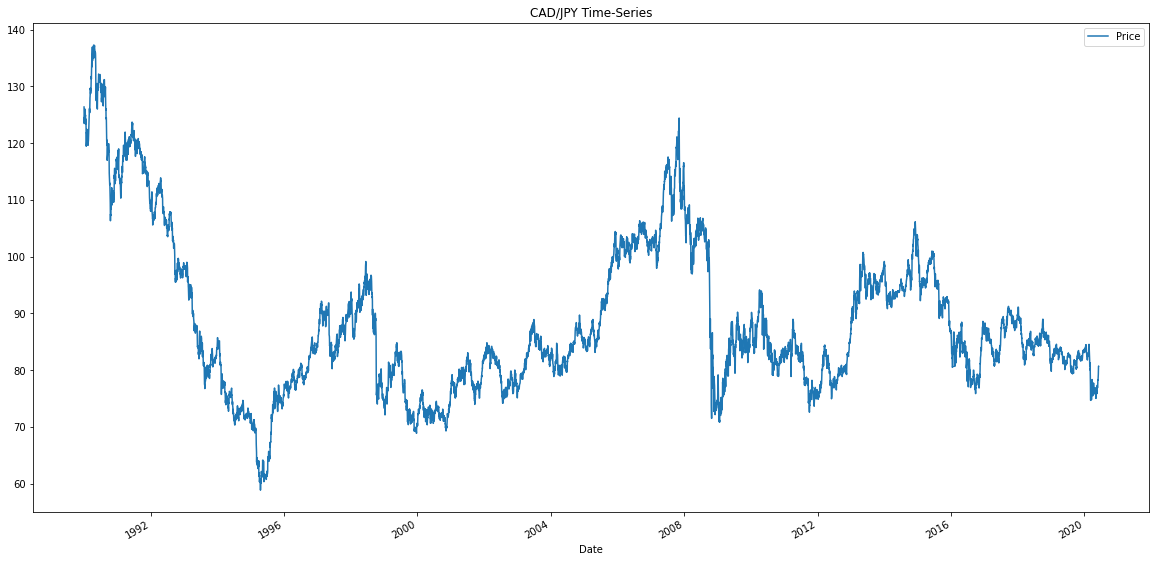

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(
    figsize=[20,10],
    title='CAD/JPY Time-Series',
    legend=True
)

**Question:** Do you see any patterns, long-term and/or short? 

Pre-1996 and the 2008 saw peaks CAD v. YEN strength. Due to degradation of CAD buying power during the time pre-1992-2021+ period, short term outlook points to a continuation of the trend. 
 
Longer term, where there are peak values pre-1992 and between 2007-2008 and deep downward trends in 1996 and 2009, much of the CAD/YEN relationship was stable. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend=sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
price_noise_trend_df=cad_jpy_df[['Price']].copy()
price_noise_trend_df['Noise']=cad_jpy_noise
price_noise_trend_df['Trend']=cad_jpy_trend

price_noise_trend_df.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Exchange Rate Price vs. Trend 2015 to Present'}, xlabel='Date'>

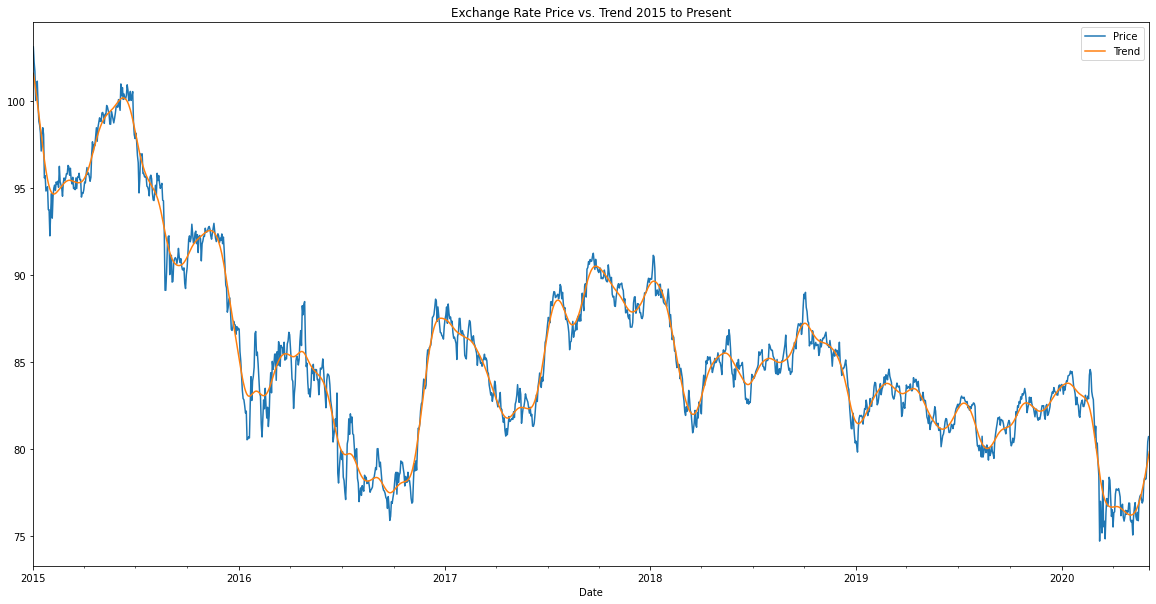

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
price_noise_trend_df.loc['2015':,['Price','Trend']].plot(
    figsize=[20,10],
    title='Exchange Rate Price vs. Trend 2015 to Present',
    legend=True
)

**Question:** Do you see any patterns, long-term and/or short?

Using the HP filter reveals the overall Trend. Short Term seemingly there are 2 quarter uptrends that follow dips. Long term there is an overall downtrend.

<AxesSubplot:title={'center':'Noise 2015 to Present'}, xlabel='Date'>

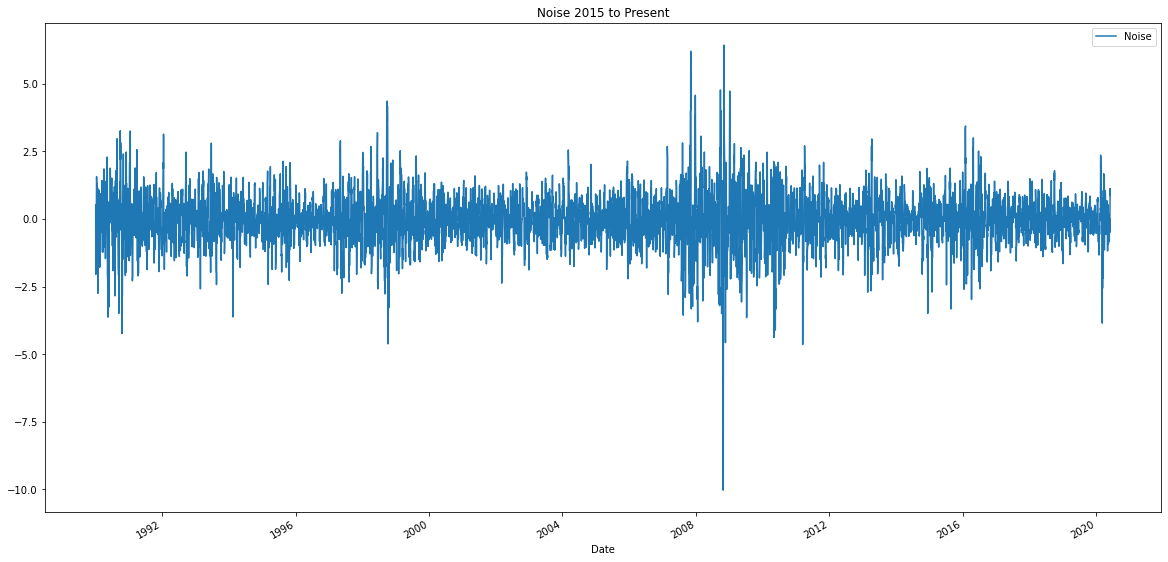

In [8]:
# Plot the Settle Noise
price_noise_trend_df.loc[:,'Noise'].plot(
  figsize=(20,10),
  title ='Noise 2015 to Present',
  legend=True
)

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=(cad_jpy_df[['Price']].pct_change()*100)
returns=returns.replace(-np.inf, np.nan).dropna()

returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_statsmodel=ARMA(returns.values,order=(2,1))

# Fit the model and assign it to a variable called results
results=arma_statsmodel.fit()

/Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23010D+00    |proj g|=  3.45568D-04

At iterate    5    f=  1.23010D+00    |proj g|=  3.61489D-05

At iterate   10    f=  1.23010D+00    |proj g|=  3.51275D-04


 This problem is unconstrained.



At iterate   15    f=  1.23008D+00    |proj g|=  2.93563D-03

At iterate   20    f=  1.23007D+00    |proj g|=  9.99201D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     39      1     0     0   4.441D-08   1.230D+00
  F =   1.2300678291595355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 29 Jan 2022   AIC                          19513.955
Time:                        20:07:32   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1699           +0.0000j           42.1699            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

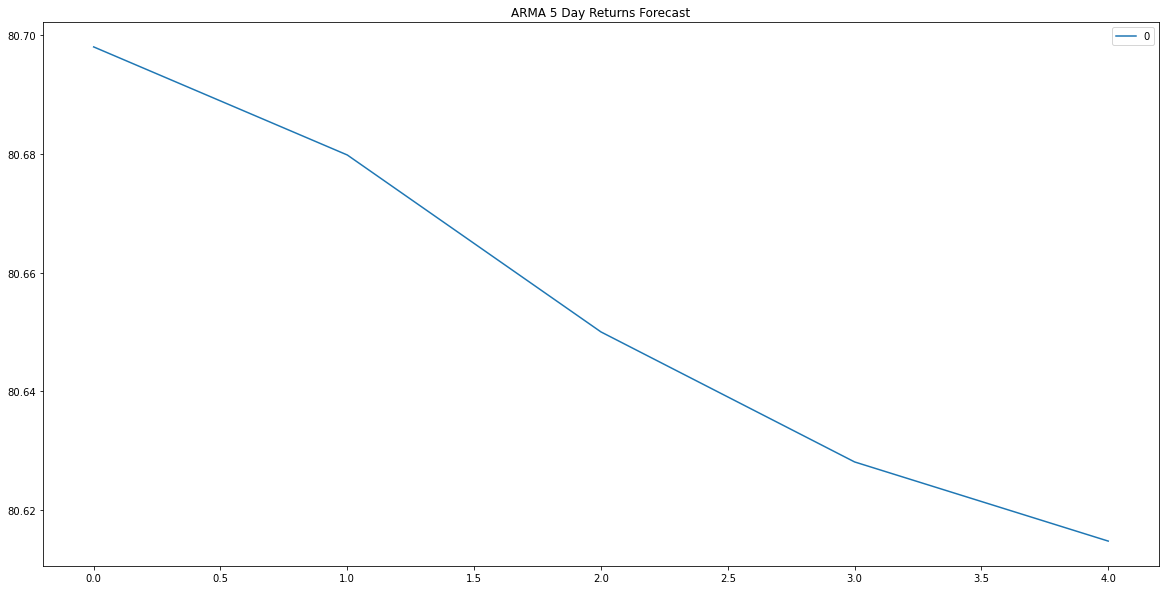

In [24]:
# Plot the 5 Day Returns Forecast
arma_5d_plot=pd.DataFrame(results.forecast(steps=5)[0]).plot(
  figsize=(20,10),
  title='ARMA 5 Day Returns Forecast',
  legend=True
)

**Question:** Based on the p-value, is the model a good fit?

Based on the p-value this model does not appear to be a good fit.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [13]:
# Estimate and ARIMA Model:
arima_statsmodel = ARIMA(
    cad_jpy_df['Price'], 
    order=(
        5,
        1,
        1
    )
)

# Fit the model
results=arima_statsmodel.fit()

/Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWar

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10313D+00    |proj g|=  1.92935D-04

At iterate    5    f=  1.10313D+00    |proj g|=  5.81757D-06

At iterate   10    f=  1.10313D+00    |proj g|=  3.35509D-05


 This problem is unconstrained.



At iterate   15    f=  1.10313D+00    |proj g|=  5.36682D-05

At iterate   20    f=  1.10313D+00    |proj g|=  8.65974D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     27      1     0     0   2.220D-08   1.103D+00
  F =   1.1031309576182682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Sat, 29 Jan 2022   AIC                          17507.244
Time:                        20:07:33   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1892           +0.0000j            2.1892            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Price Forecast'}>

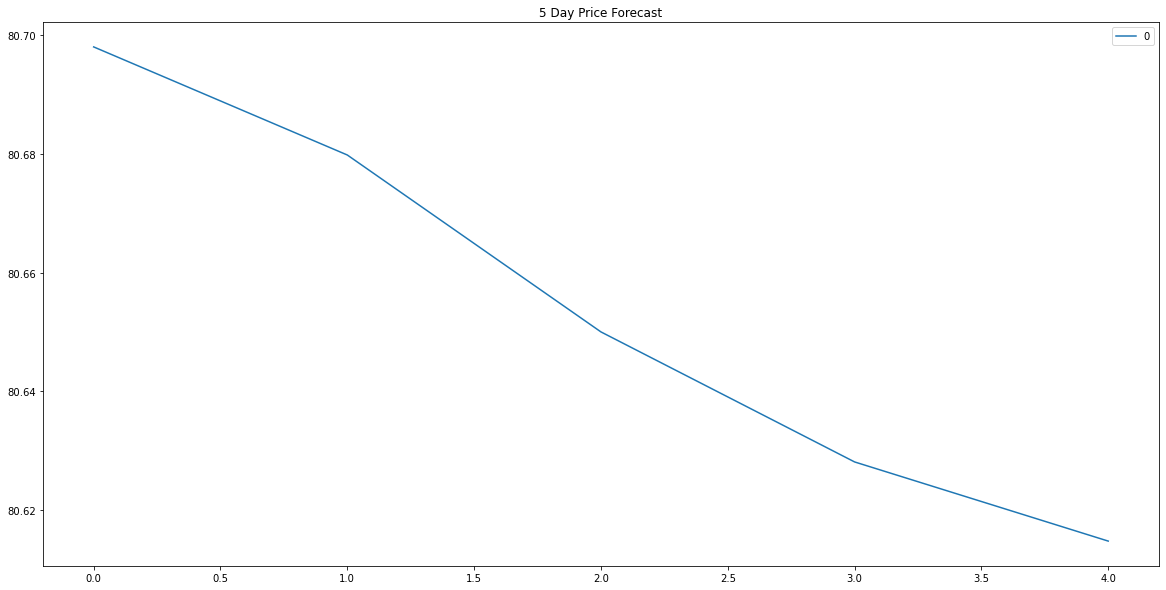

In [25]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(
    figsize=(20,10),
    title='5 Day Price Forecast',
    legend=True
)

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

Based on the p-value this model does not appear to be a good fit and it forecasts a near term downward trend for JPY.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch

from arch import arch_model

In [17]:
# Estimate a GARCH model:
garch_model = arch_model(
    returns,
    mean='Zero',
    vol='GARCH',
    p=2,
    q=1
)

# Fit the model
garch_results=garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 306850859.3384427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838861417698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11771.663036006626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.31072801688
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.369930732108
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.112105819691
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027322298947
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.022077988246
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021067661106
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020797453917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764880363
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.020764882265
Optimization terminated successfully    (Exit mode 0)
         

In [18]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sat, Jan 29 2022   Df Residuals:                     7928
Time:                        20:07:34   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts=garch_results.forecast(
    start=last_day,
    horizon=forecast_horizon
)

forecasts

/Users/mbl/opt/anaconda3/envs/sqlalchemy__pyvizenv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'JPY 5 Day Forecast of Volatility'}>

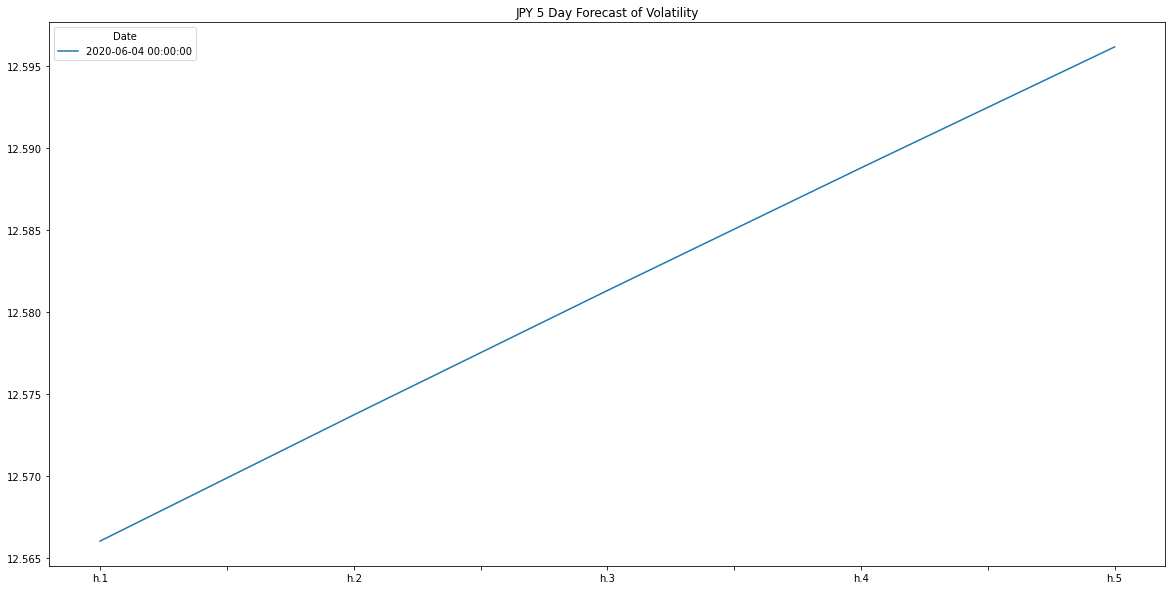

In [26]:
# Plot the final forecast
final.plot(
    figsize=(20,10),
    title='JPY 5 Day Forecast of Volatility',
    legend=True
)

**Question:** What does the model forecast will happen to volatility in the near term?

This model points to near term volatility.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

The above JPY modeling was not an ideal fit buying would not be advisable. Better modeling required.

2. Is the risk of the yen expected to increase or decrease?

The JPY 5 Day Forecast of Volatility graph forecasts increasing short term volitility.

3. Based on the model evaluation, would you feel confident in using these models for trading?

Modeling establishes that more modeling is required for a high confidence buy.